### Bar plot of Figure of Merit for MS v1.5

- [time gaps](#time-gaps)
- [depth](#depth)
- [footprint](#footprint)
- [proper motion](#proper-motion)
- [all](#all)

In [232]:
pwd

'/home/idies/workspace/Storage/lixl/persistent/LSSTunknowns/tdAnom'

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [103]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"


In [104]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [105]:
def scale(arr, mode=0, fmax=1):
    """scale array by max, or given fmax"""
    
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    elif mode==2:
        # scale input max
        newarr = arr / fmax
        
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]


In [106]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0, fmax=1):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode, fmax=fmax) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new



In [107]:
# get the name of all opsim dbs 
import os
import glob

workpath = os.getcwd()
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps'
os.chdir(workpath) # change back to work directory
dblist_all.sort()


In [81]:
#dblist_all

In [108]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



In [173]:
def plot_barh_v2(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    # modify labels
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
        if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
            tl.set_backgroundcolor("#E5E7E9")
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
            
        #tl.set_text(txt)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
        

### time gaps

In [63]:
fomcsv = './data_v1_5/df_tgapsFoM_'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all)


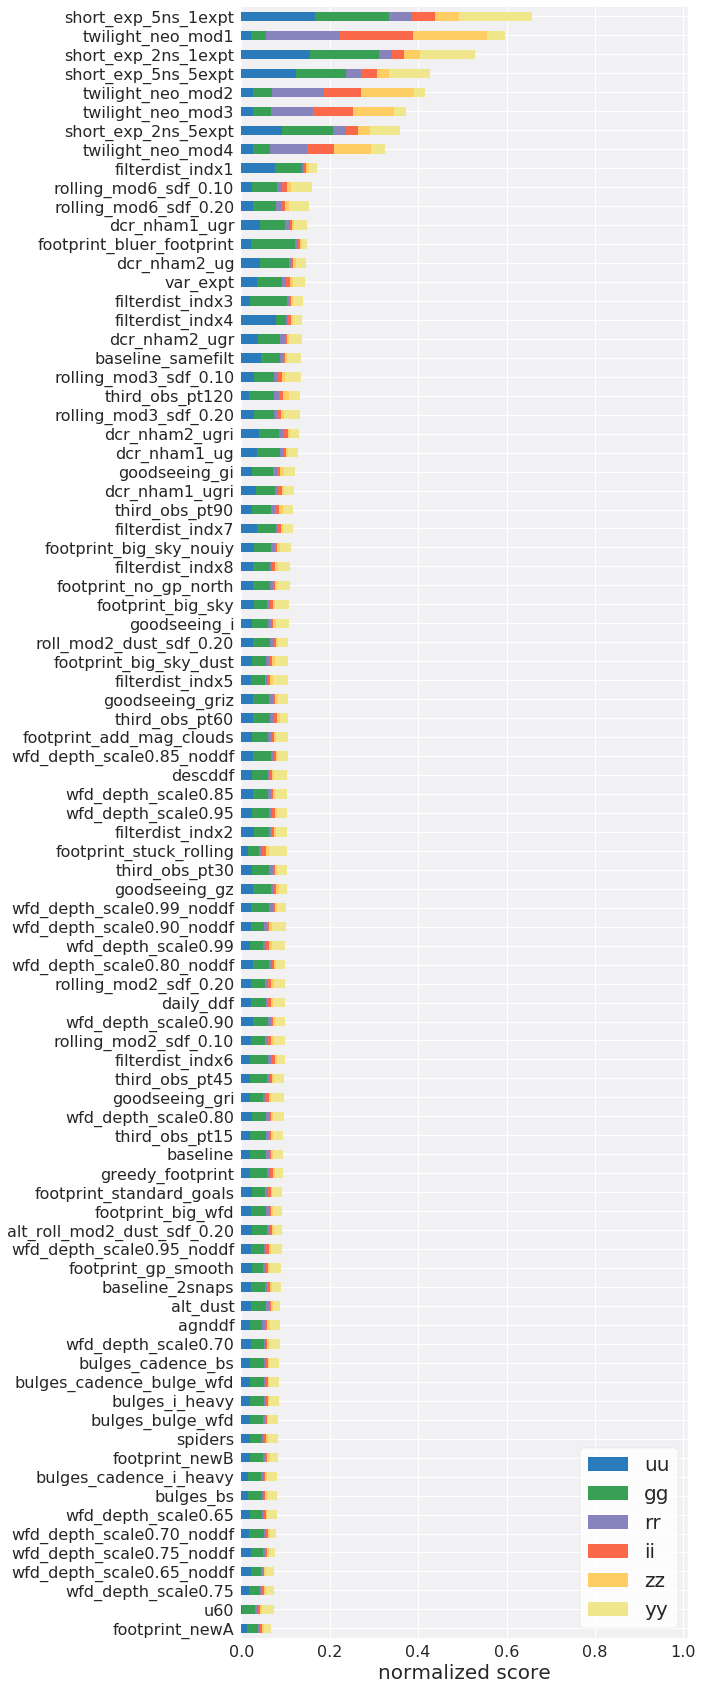

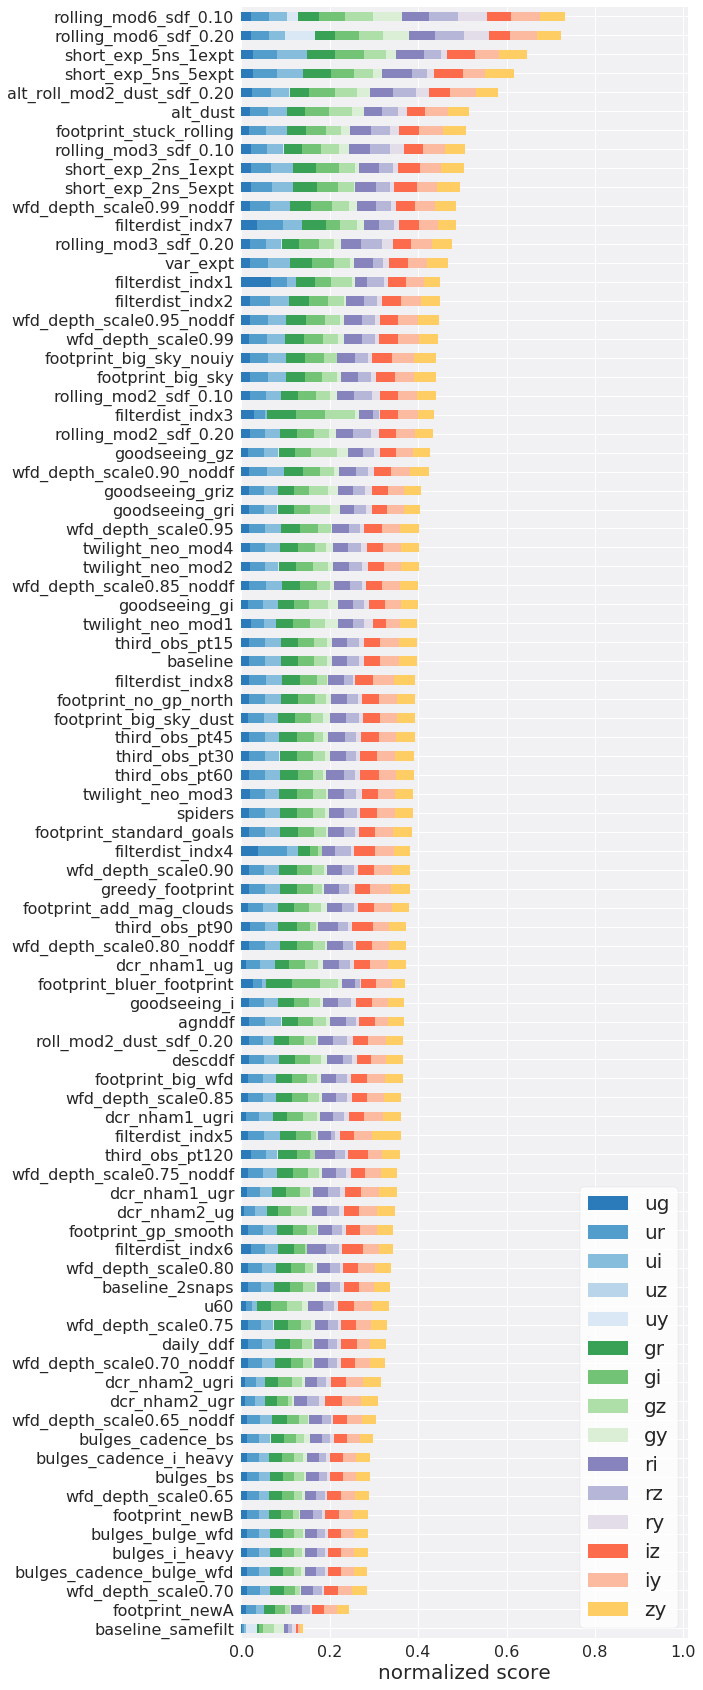

In [64]:
plot_barh(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_tgaps_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_tgaps_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### depth

In [17]:
mag_stretch = {'u':24.0, 'g':25.1, 'r':24.8, 'i':24.1, 'z':23.4, 'y':22.2 }


In [25]:
df_mag = pd.read_csv('./data_v1_5/df_depth_wfd.csv')


In [39]:
# get difference to goal
for f in filters:
    df_mag[f] = df_mag[f] - mag_stretch[f]

In [47]:
df_norm = get_df_norm(df = df_mag, cols=filters, mode=1)



In [65]:
#fomcsv = './data_v1_5/df_depth_wfd.csv'
#df_norm = get_df_norm(fomcsv = fomcsv, cols=filters, mode=1)
#

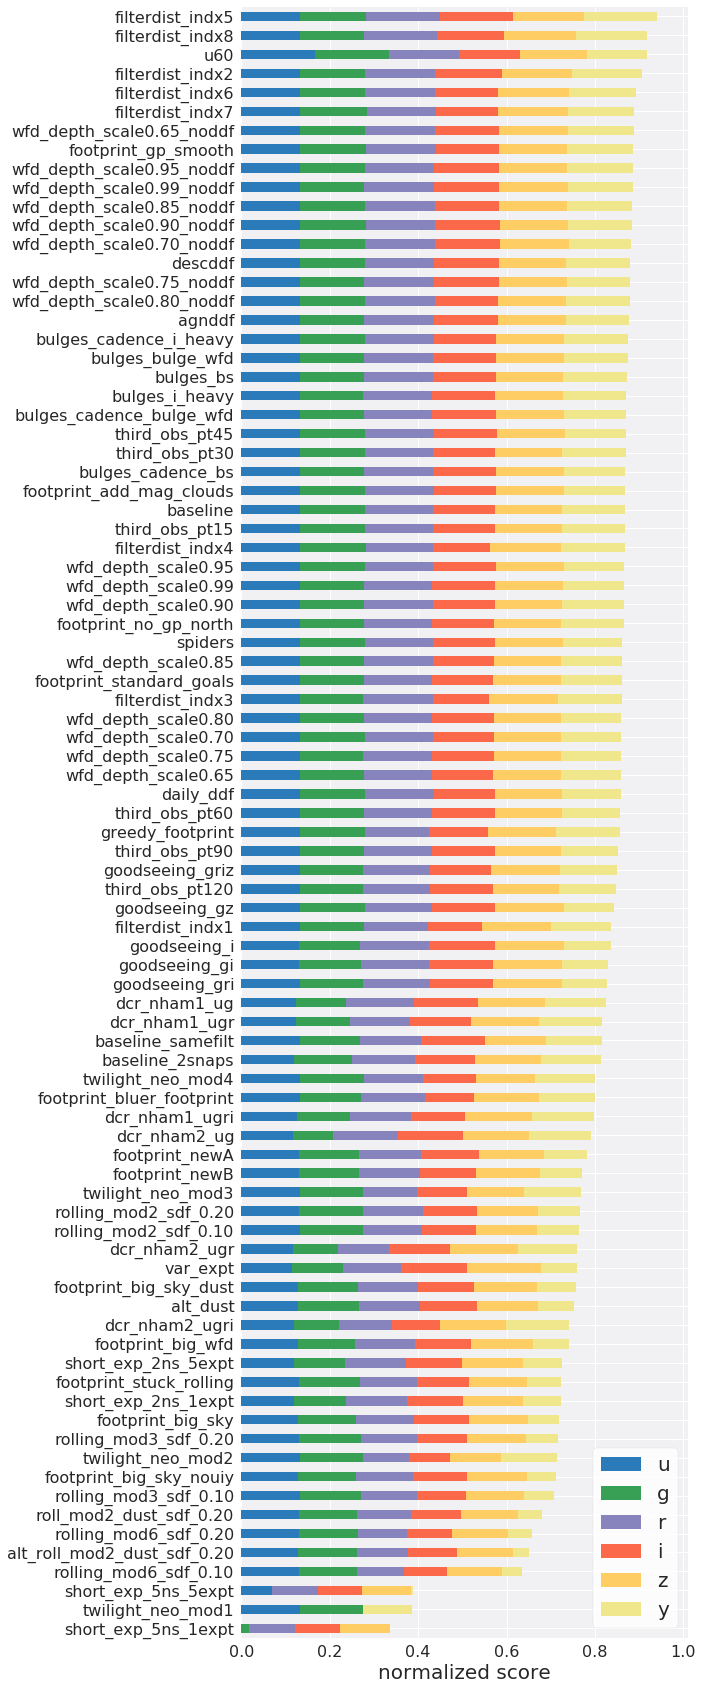

In [48]:
plot_barh(df_norm, colon=filters, byfamily=False, savefig='figures/barh_depth_wfd.pdf', colormap=get_mycmap(pairs='same')) 



### footprint

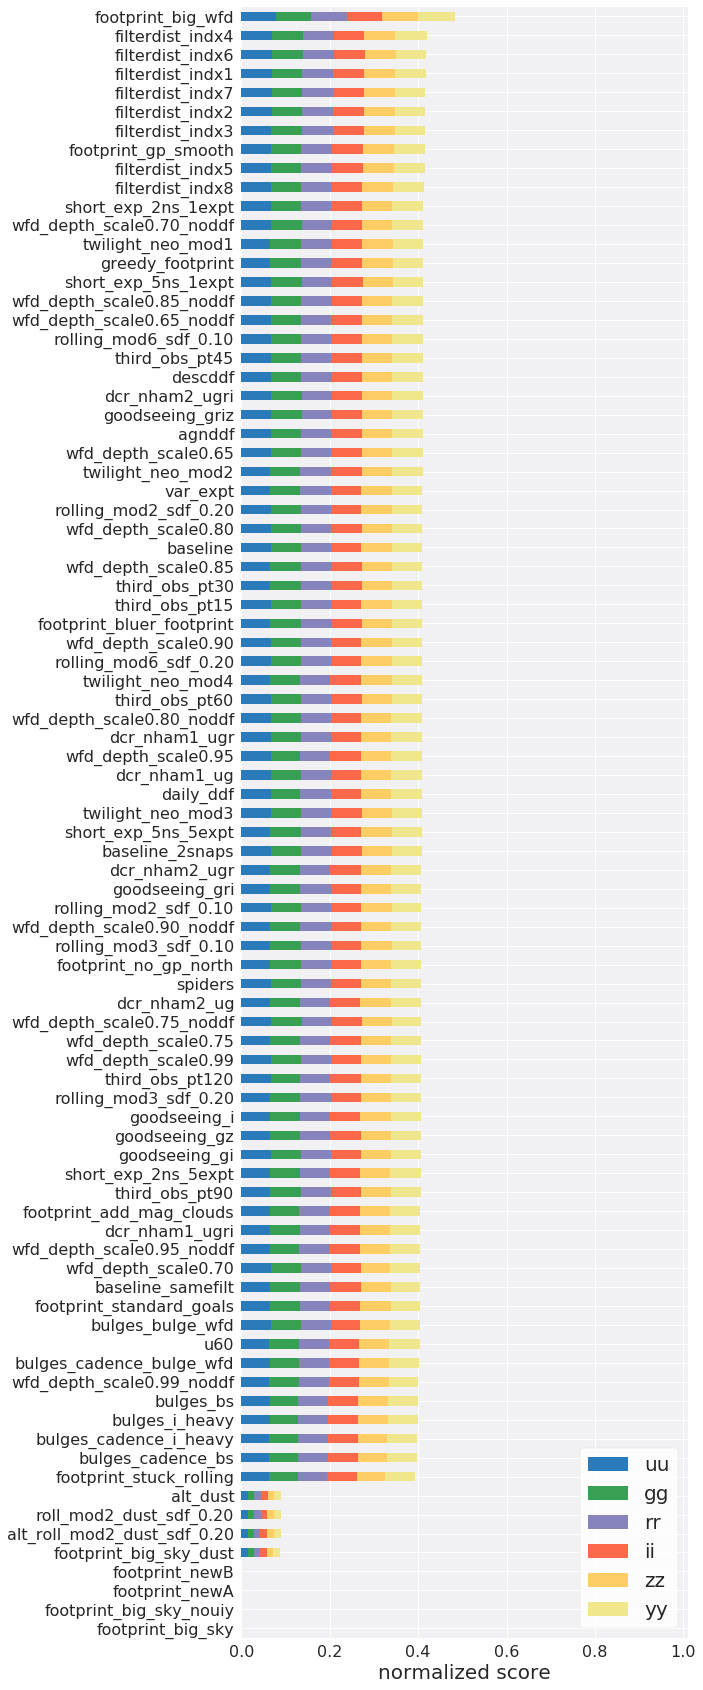

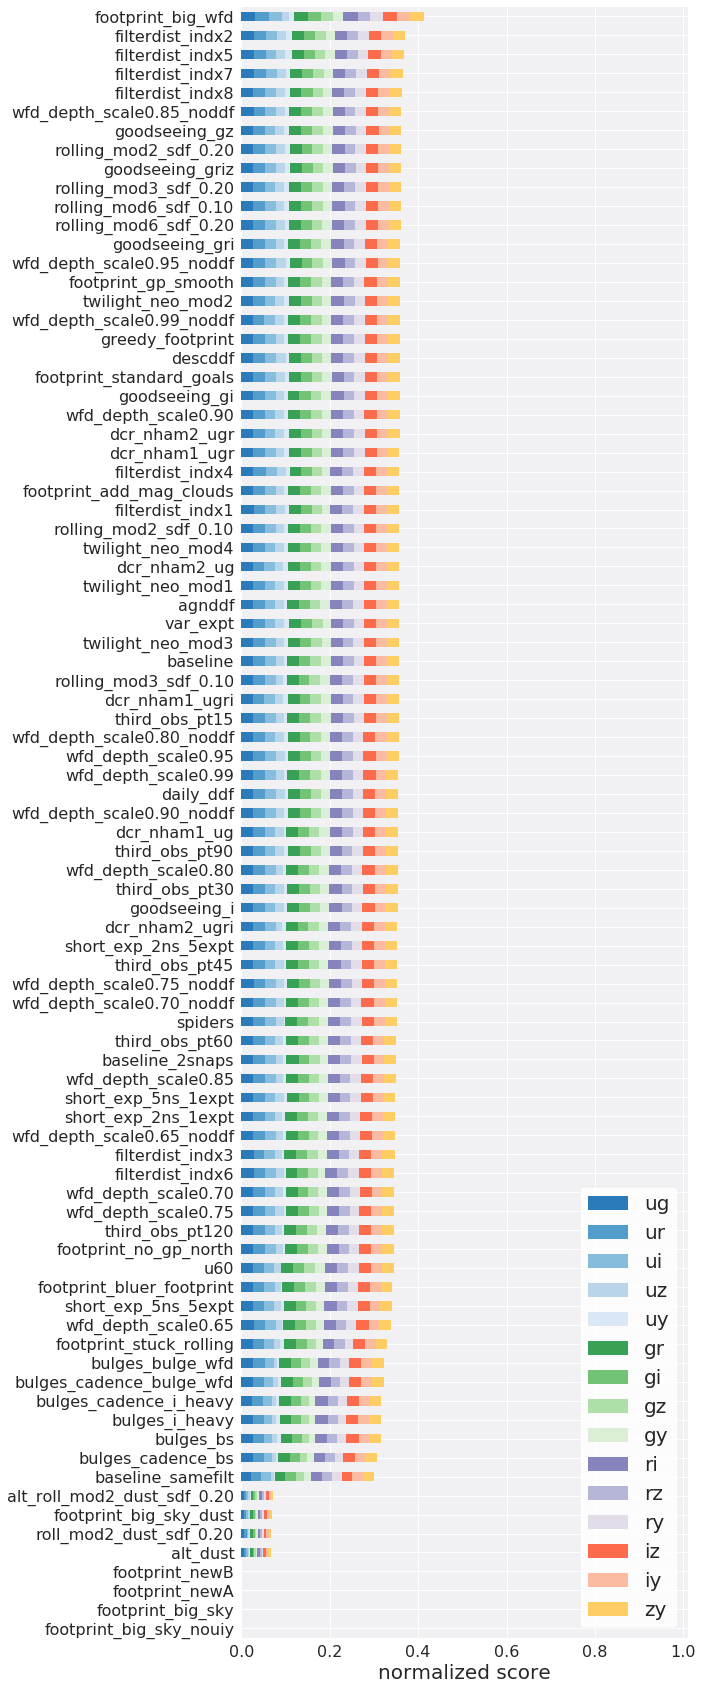

In [98]:
fomcsv = './data_v1_5/df_Nfields_GP_inwfd_2d_raw.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all, mode=2, fmax=250)

plot_barh(df_norm, colon=cols_same, byfamily=False, savefig=None, colormap=get_mycmap(pairs='same')) 
plot_barh(df_norm, colon=cols_diff, byfamily=False, savefig=None, colormap=get_mycmap(pairs='diff') ) 



### star density

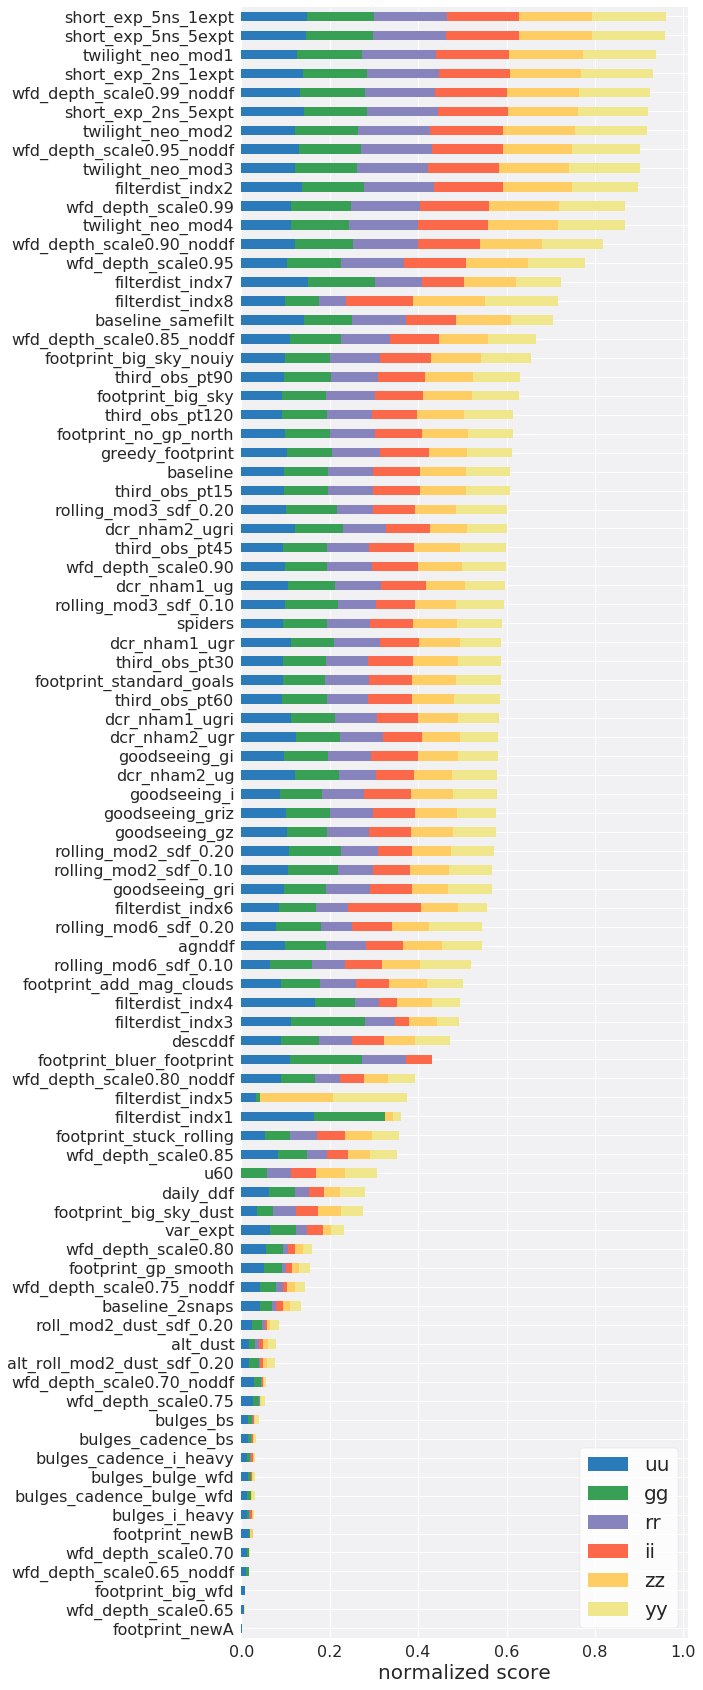

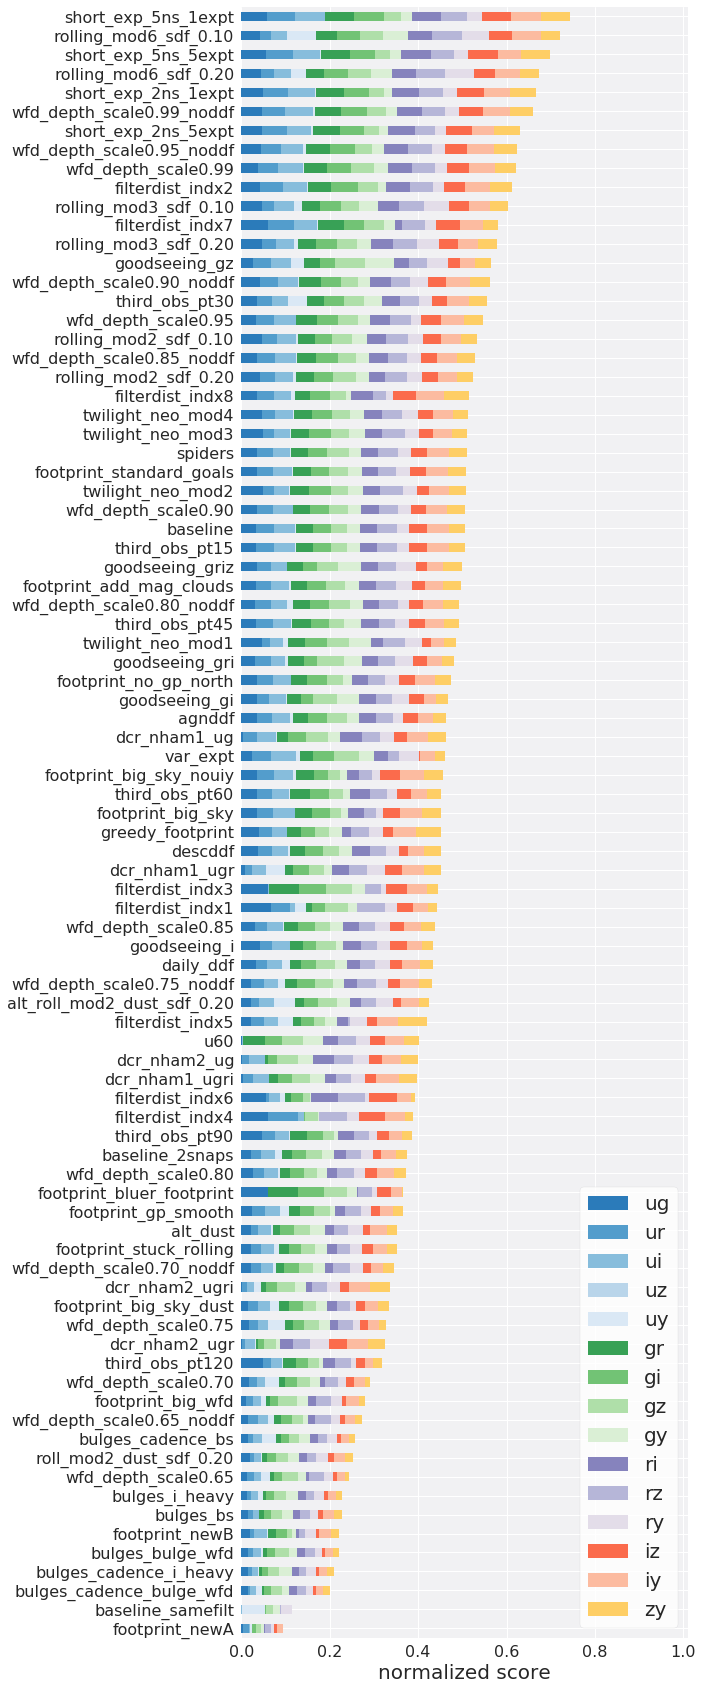

In [100]:
fomcsv = './data_v1_5/df_Nstars_wfd.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all)

plot_barh(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_nstars_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_nstars_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### proper motion

### prepare df_radar

In [211]:

# for wfd
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_wfd.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_wfd.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_wfd.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_wfd.csv')

# for all
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_all_noddf.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_all.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_all.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_all.csv')

# for GP inwfd
#msname = "GP_inwfd"
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_GP_inwfd.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_GP_inwfd_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_GP_inwfd_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_GP_inwfd.csv')

# for GP all
#msname = "GP_allsky"
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_GP_allsky.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_GP_allsky_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_GP_allsky_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_GP_all.csv')


# for LMC inwfd
#msname = "LMC_inwfd"
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_LMC_inwfd.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_LMC_inwfd_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_LMC_inwfd_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_LMC_inwfd.csv')

# for LMC all
#msname = "LMC_allsky"
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_LMC_allsky.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_LMC_allsky_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_LMC_allsky_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_LMC_all.csv')

# for SMC inwfd
#msname = "SMC_inwfd"
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_SMC_inwfd.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_SMC_inwfd_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_SMC_inwfd_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_SMC_inwfd.csv')

# for SMC all
#msname = "SMC_allsky"
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_SMC_allsky.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_SMC_allsky_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_SMC_allsky_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_SMC_all.csv')



In [205]:
df_nfields.head(3)

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,agnddf_v1.5_10yrs.db,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,alt_dust_v1.5_10yrs.db,2,2,2,2,1,0,3,3,3,...,4,4,4,3,4,4,4,4,4,4
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,2,2,3,3,0,0,3,4,3,...,4,4,4,3,4,3,3,4,4,4


In [179]:
# get max number to normalize
#pd.read_csv("./data_v1_5/df_Nstars_SMC_allsky_2d_raw.csv").max()

In [180]:
dic_fmax = {"fields_GP":254, "stars_GP":308250875, 
            "fields_LMC":12, "stars_LMC":27143557, 
            "fields_SMC":5, "stars_SMC":1934691,}



In [212]:
# normalize
ms = 'SMC'  # used to get largest fields/stars value

for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_tgaps[col] = scale(df_tgaps[col])
    df_nfields[col] = scale(df_nfields[col], mode=2, fmax=dic_fmax[f'fields_{ms}'] )
    df_nstars[col] = scale(df_nstars[col], mode=2, fmax= dic_fmax[f'stars_{ms}'] )

for col in filters:
    df_depth[col] = scale(df_depth[col], mode=1)

df_tgaps['total_same'] = scale( np.sum(df_tgaps[ cols_same ], axis=1) )
df_tgaps['total_diff'] = scale( np.sum(df_tgaps[ cols_diff ], axis=1) )

#df_nfields['total'] = scale( np.sum(df_nfields[ cols_all ], axis=1) )

#df_nstars['total'] = scale( np.sum(df_nstars[ cols_all ], axis=1) )

df_nfields['total'] = np.mean(df_nfields[ cols_all ], axis=1)

df_nstars['total'] = np.mean(df_nstars[ cols_all ], axis=1)

df_depth['total'] = scale( np.sum(df_depth[ filters ], axis=1) )



In [132]:
def show_opsims(dbDir):
    '''Show available opsim databases in the provided directory.

    Args:
        dbDir(str): The path the database directory.
    '''

    dbDir = os.path.abspath(dbDir)
    db_list = glob.glob(dbDir+'/*.db')
    runNames = [os.path.splitext(os.path.basename(x))[0] for x in db_list]

    return runNames

runNames = show_opsims(dbpath)
runNames.sort()

In [213]:
msname

'SMC_allsky'

In [214]:
#msname =
df_radar = pd.DataFrame()
df_radar['db'] = runNames

df_radar['brightness'] = df_tgaps['total_same'] 
df_radar['color'] = df_tgaps['total_diff'] 

df_radar['footprint'] = df_nfields['total']
df_radar['star density'] = df_nstars['total']
df_radar['depth'] = df_depth['total']
df_radar['family'] = df_radar.apply(get_family, axis=1)

# save file 
df_radar.to_csv('./data_v1_5/df_radar_{}.csv'.format(msname), index=False)

### all by family

In [159]:
#fomcsv = './data_v1_5/df_radar_wfd.csv'
#msname = 
fomcsv = './data_v1_5/df_radar_{}.csv'.format(msname)

df_fom = pd.read_csv(fomcsv)
df_fom['family'] = df_fom.apply(get_family, axis=1)

df_fom.head()

,db,brightness,color,footprint,star density,depth,family
0,agnddf_v1.5_10yrs,0.221947,0.473526,0.285527,0.098507,0.916555,agnddf
1,alt_dust_v1.5_10yrs,0.019954,0.022532,0.035996,0.018637,0.638816,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,0.021795,0.052007,0.036558,0.019173,0.591380,alt
3,baseline_2snaps_v1.5_10yrs,0.188484,0.439708,0.270904,0.092166,0.854541,baseline
4,baseline_samefilt_v1.5_10yrs,0.244897,0.058397,0.226847,0.078792,0.868989,baseline


In [136]:
FoMvars = ['brightness', 'color', 'depth', 'footprint', 'star density', ]


In [137]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


In [215]:
#msname = 'GP_inwfd'
msname

'SMC_allsky'

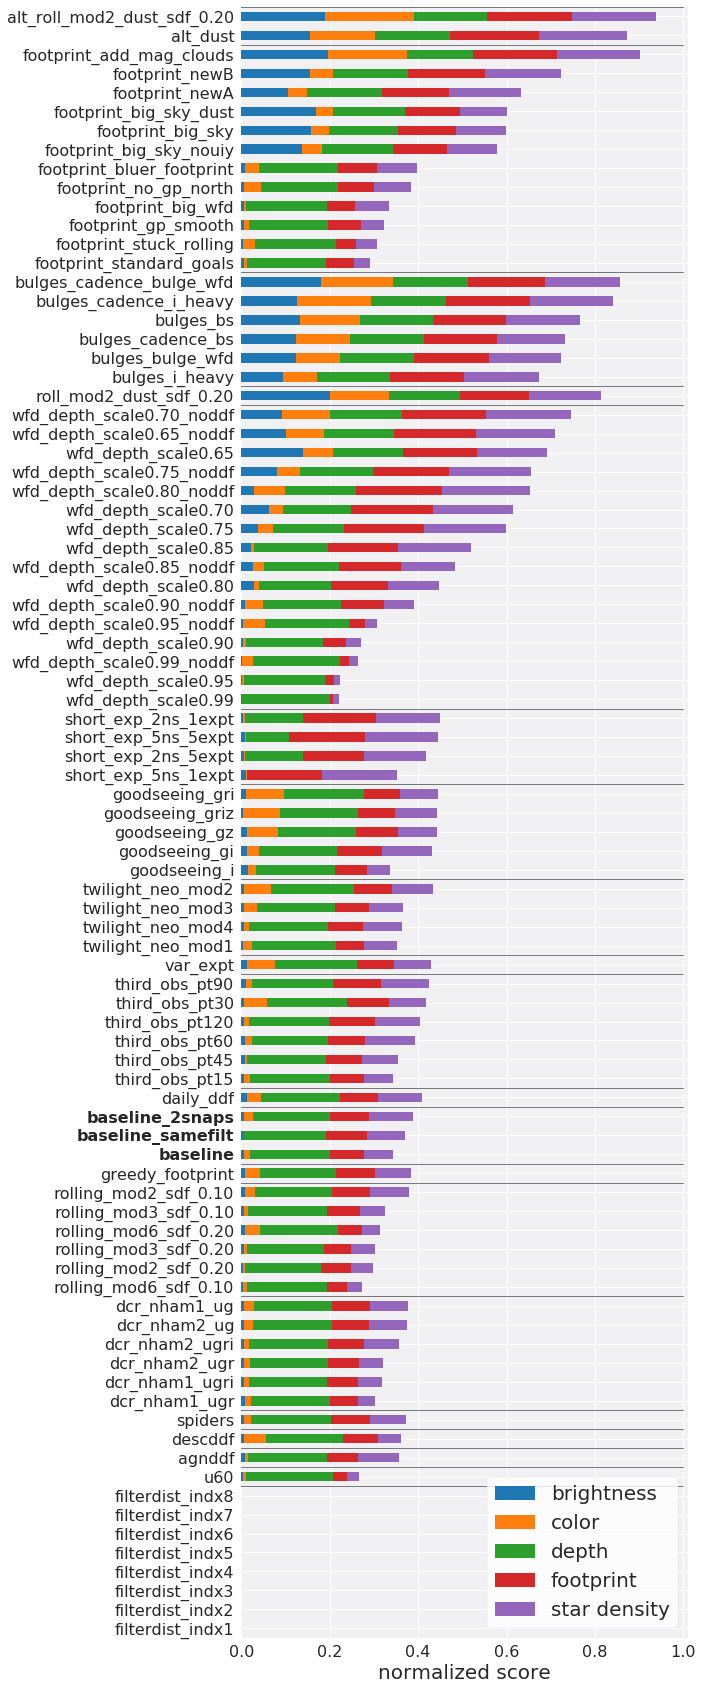

In [216]:
#fomcsv = './data_v1_5/df_radar_wfd.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

fomcsv = f'./data_v1_5/df_radar_{msname}.csv'
df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)


plot_barh_v2(df_norm, colon=FoMvars, byfamily=True, savefig=f'figures/barh_family_{msname}.pdf', colormap=mymap ) 



In [12]:
df_norm.head()

,db,FoM_tgaps_same,FoM_tgaps_diff,FoM_depth,FoM_EG,FoM_Gal,family
0,agnddf,0.132988,0.503818,0.931742,0.564762,0.604740,agnddf
1,alt_dust,0.133044,0.703636,0.800220,0.554701,0.340651,alt
2,alt_roll_mod2_dust_sdf_0.20,0.138956,0.795575,0.692088,0.644424,0.404541,alt
3,baseline_2snaps,0.135375,0.461125,0.863893,0.330473,0.379226,baseline
4,baseline_samefilt,0.206479,0.190582,0.866805,0.357034,0.352019,baseline


### plot radar

In [50]:
def plot_radar(r, ax=None, fill=True, figsize=(6,6), **kwargs):
    """plot a radar 
    Inputs: r, list like"""
    
    if ax==None:
        fig, ax = plt.subplots(1,1,figsize=figsize, subplot_kw={'projection': 'polar'} )
    
    r = list(r)
    N = len(r)
    r.append( r[0] )  # repeat first to close circle

    # get angle for each value
    theta = [n * 2 * np.pi / N  for n in range(N) ]
    theta.append( theta[0] )
    
    ax.plot(theta, r, **kwargs)
    if fill:
        ax.fill(theta, r, alpha=0.1)
    ax.set_xticks(theta[:-1], );
    #ax.set_xticklabels( ['v1', 'v2'] );
    ax.spines['polar'].set_visible(False)  # 不显示极坐标最外圈的圆
    return ax
    



In [64]:
dbnames[3]

'rolling_mod6_sdf_0.10_v1.5_10yrs'

[0.94094463 0.72724124 0.49584036 0.62029182 0.30320612]
[0.14567215 0.44244225 0.98302057 0.41092637 0.10738459]
[0.2813333  0.98828716 0.9705465  1.         1.        ]
[0.25415545 0.80183965 0.88243318 0.38683407 0.12511301]
[0.61774695 0.42087785 0.85568226 0.41194435 0.15089617]


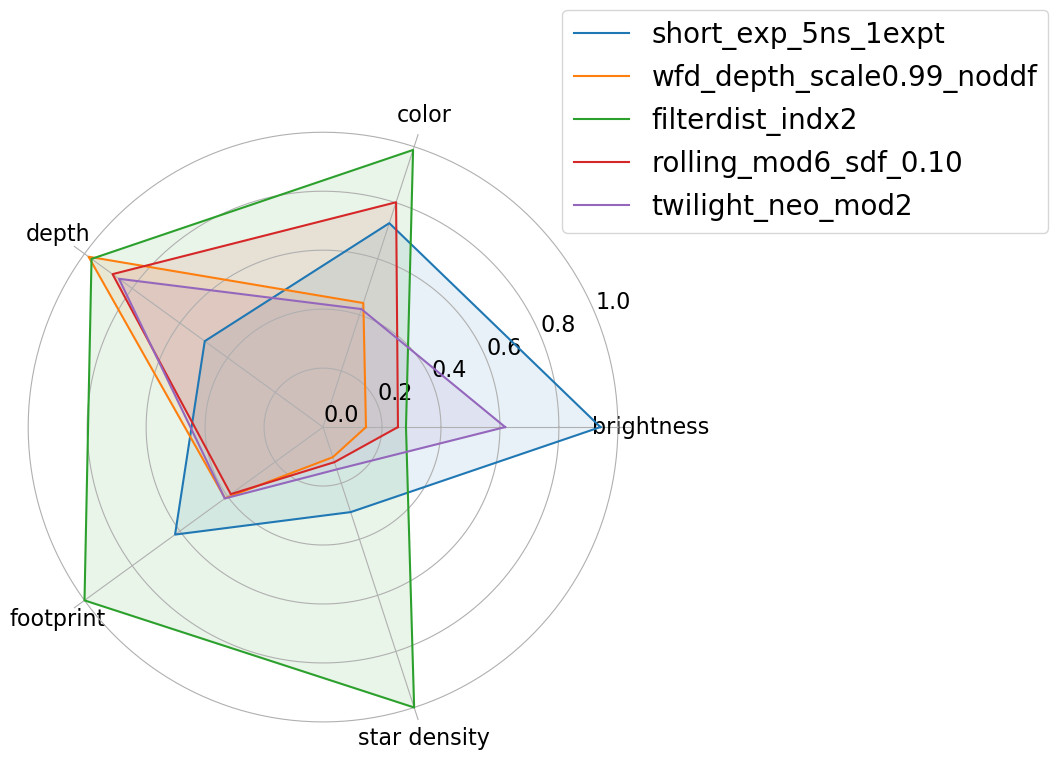

In [70]:
plt.style.use('default')
#plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

dbnames = [ #'baseline_v1.5_10yrs', 'footprint_big_skyv1.5_10yrs',
           #'twilight_neo_mod1_v1.5_10yrs',
           #'wfd_depth_scale0.99_v1.5_10yrs'
           'short_exp_5ns_1expt_v1.5_10yrs',
           'wfd_depth_scale0.99_noddf_v1.5_10yrs',
           #'bulges_bs_v1.5_10yrs',
           'filterdist_indx2_v1.5_10yrs',
           'rolling_mod6_sdf_0.10_v1.5_10yrs',
           'twilight_neo_mod2_v1.5_10yrs',
           #'footprint_big_sky_nouiyv1.5_10yrs'  
          ]

FoMvars = ['FoM_tgaps_same', 'FoM_tgaps_diff', 'FoM_depth', 'FoM_EG', 'FoM_Gal', ]

#FoMvars = ['FoM_tgapsEvol', 'FoM_tgapsCol', 'FoM_depth', 'FoM_EG', 'FoM_Gal', ]


fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection': 'polar'} )

for dbname in dbnames:
    r = df_radar[ df_radar.db==dbname ][FoMvars].values.flatten()
    print(r)
    label = dbname.replace("_v1.5_10yrs", "").replace("v1.5_10yrs", "")
    ax = plot_radar(r=r, label=label, fill=True, ax=ax)

FoMvarsnames = ['brightness', "color", "depth", "footprint", "star density"]#,
ax.set_xticklabels(FoMvarsnames, );
ax.set_yticks([0, .2, .4, .6, .8, 1])
#ax.set_rlabel_position(0)
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.2))

plt.savefig("figures/radar_{}.pdf".format(msname), bbox_inches='tight')




### prepare csv file for d3js

In [217]:
def replace_dot(df):
    """replace . in dbname by _ for d3js"""
    dbname = df['db'].replace("_v1.5_10yrs", "").replace("v1.5_10yrs", "").replace(".", "_")
    return dbname
    
def get_df_radar_d3js(df_radar):
    """get csv data for d3js radar plot"""
    df_radar['db'] = df_radar.apply(replace_dot, axis=1)
    df_radar_t = df_radar.set_index('db').T.reset_index().rename(columns={'index':'section'})
    return df_radar_t
    

In [218]:
glob.glob('./data_v1_5/df_radar*')

['./data_v1_5/df_radar_wfd.csv',
 './data_v1_5/df_radar_all.csv',
 './data_v1_5/df_radar_GP_inwfd.csv',
 './data_v1_5/df_radar_GP_allsky.csv',
 './data_v1_5/df_radar_LMC_inwfd.csv',
 './data_v1_5/df_radar_LMC_allsky.csv',
 './data_v1_5/df_radar_SMC_inwfd.csv',
 './data_v1_5/df_radar_SMC_allsky.csv']

In [231]:
for fomcsv in glob.glob('./data_v1_5/df_radar*'):
    s = fomcsv.split('/')[-1].replace('.csv', '')
    
    df_radar = pd.read_csv(fomcsv)

    df_radar = df_radar.drop('family', axis=1)

    df_radar_t = get_df_radar_d3js(df_radar)
    df_radar_t.to_csv(f"./data_v1_5/{s}_t.csv", index=False)
    print(fomcsv)
    
    

./data_v1_5/df_radar_wfd_v1_5_v1_7.csv
./data_v1_5/df_radar_all_v1_5_v1_7.csv


KeyError: "['family'] not found in axis"

In [ ]:

fomcsv = './data_v1_5/df_radar_wfd.csv'


